In this notebook we study the tradeoff between
nat-err and rob-err
for SVMs on MNIST and CIFAR10.

### Set up libraries

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
from typing import Dict, Tuple
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import thundersvm

import jax
import jax.numpy as jnp
from jax.interpreters import xla
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

import neural_tangents as nt
from neural_tangents import stax

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [3]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset, attacks, jthunder, kernel

### Load Data

In [4]:
%%time

MNIST_TRAIN = dataset.get_np_data(
    name="mnist", split="train", binary_labels=True)
MNIST_TEST = dataset.get_np_data(
    name="mnist", split="test", binary_labels=True)

CIFAR_TRAIN = dataset.get_np_data(
    name="cifar10", split="train", binary_labels=True)
CIFAR_TEST = dataset.get_np_data(
    name="cifar10", split="test", binary_labels=True)

print(MNIST_TRAIN.xs.shape)
print(MNIST_TEST.xs.shape)
print(CIFAR_TRAIN.xs.shape)
print(CIFAR_TEST.xs.shape)

(60000, 784)
(10000, 784)
(50000, 3072)
(10000, 3072)
CPU times: user 23.8 s, sys: 27.7 s, total: 51.4 s
Wall time: 8.42 s


[0 0 0 1 1 0 0 1 0 1]


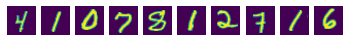

[0 0 0 1 1 1 0 1 0 0]


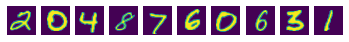

[1 1 0 0 1 1 0 1 1 1]


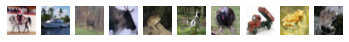

[1 0 1 1 1 0 1 0 0 0]


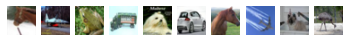

In [5]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

### Utility code

In [6]:
def ds_prefix(ds: dataset.Dataset, sz: int) -> dataset.Dataset:
    return dataset.Dataset(name=f"{ds.name}[:{sz}]", xs=ds.xs[:sz], ys=ds.ys[:sz])

def avg_by_cls(xs, ys) -> Tuple[float, float]:
    return (xs[ys == 0].mean(), xs[ys == 1].mean())

def accs_by_cls(clf: thundersvm.SVC, ds: dataset.Dataset) -> Tuple[float, float]:
    return avg_by_cls(clf.predict(ds.xs) == ds.ys, ds.ys)

def fmt_accs(accs: Tuple) -> str:
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

def print_dict(d: Dict):
    def fmt(v):
            if isinstance(v, tuple):
                return fmt_accs(v)
            elif isinstance(v, float):
                return f"{v:.2e}"
            return v
            
    print({
        k : fmt(v) for
        k, v in d.items()
        if not isinstance(v, np.ndarray)
    })

In [7]:
def eval_ds(
    clf: thundersvm.SVC,
    ds: dataset.Dataset,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    batch_size: int
) -> Dict:
    res_dict = dict(
        ds_name=ds.name,
        xs=ds.xs,
        ys=ds.ys,
    )
    
    res_dict["accs"] = accs_by_cls(clf=clf, ds=ds)
    
    clf_grad_fn = jthunder.get_grad_decision_function(clf)
    
    xs_pgd = attacks.pgd(
        X=ds.xs, Y=ds.ys,
        grad_func=clf_grad_fn,
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=True,
        batch_size=batch_size,
    )
    res_dict["xs_pgd"] = xs_pgd
    
    res_dict["accs_pgd"] = accs_by_cls(clf=clf, ds=dataset.Dataset(xs=xs_pgd, ys=ds.ys))

    sfmargs = res_dict["sfmargs"] = jthunder.decision_function(clf, ds.xs).to_py() * (2 * ds.ys - 1)
    grad_norms = res_dict["grad_norms"] = np.linalg.norm(
        clf_grad_fn(ds.xs),
        axis=-1, ord=2
    )
    
    res_dict["accs_linadv"] = avg_by_cls(grad_norms * attack_eps <= sfmargs, ds.ys)
    
    return res_dict

In [8]:
def eval_clf(
    clf: thundersvm.SVC,
    datasets: dataset.Dataset,
    base_dict: Dict,
    verbose: bool,
    **kwargs,
) -> Dict:
    res_dict: dict = base_dict.copy()
    res_dict.update(dict(
        n_support=list(clf.n_support_),
        b=clf.intercept_[0],
        gam=clf._gamma,
        coef0=clf.coef0,
        **kwargs
    ))
    if verbose: print_dict(res_dict)
    
    res_dict["norm"] = np.sqrt(jthunder.norm2(clf))
    if verbose: print(f"norm={res_dict['norm']}")
    
    res_dict["ds_results"] = []
    for ds in datasets:
        ds_res_dict = eval_ds(clf, ds, **kwargs)
        res_dict["ds_results"].append(ds_res_dict)
        
        if verbose: print_dict(ds_res_dict)
    
    return res_dict

# Begin experiments

In [9]:
RESULTS = {}

## Linear kernel
The code here memory leaks unfortunately :(

In [10]:
%%time
CUR_KEY = "svm-linear"
RESULTS[CUR_KEY] = []
print(f"Running {CUR_KEY}...")

for c in [4e-6, 8e-6, 1e-5, 2e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    clf = thundersvm.SVC(kernel="linear", C=c)
    clf.fit(MNIST_TRAIN.xs[:1000], MNIST_TRAIN.ys[:1000])
    
    RESULTS[CUR_KEY].append(eval_clf(
        clf=clf,
        base_dict=dict(c=c),
        datasets=[ds_prefix(MNIST_TRAIN, 512), ds_prefix(MNIST_TEST, 512)],
        verbose=True,
        attack_eps=2.0,
        pgd_step_size=2.0/10,
        pgd_num_steps=20,
        batch_size=512,
    ))

Running svm-linear...
{'c': '4.00e-06', 'n_support': [498, 498], 'b': '9.89e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=0.003856965300462708
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '8.00e-06', 'n_support': [498, 498], 'b': '9.79e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=0.007713930600925416
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '1.00e-05', 'n_suppo

### Visualize adv. examples found via pgd
These are clipped to to have pixel values in $[0, 1]$.

Natural
[0 0 0 1 1 1 0 1 0 0]


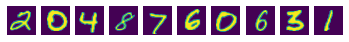


Adversarial
[0 0 0 1 1 1 0 1 0 0]


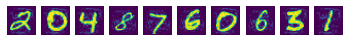

In [11]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-linear"][-1]["ds_results"][1]["xs_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

### nat-err vs. adv-err as $C$ is varied

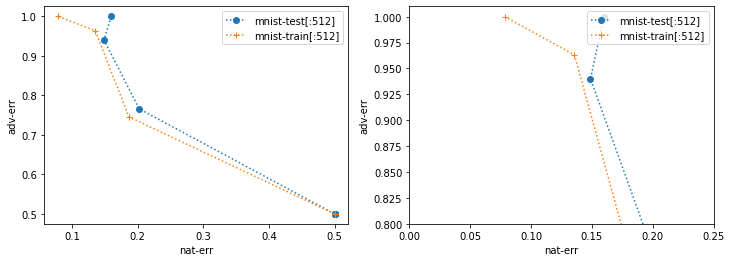

In [12]:
def main_plot():
    num_ds = len(RESULTS["svm-linear"][0]["ds_results"])
    
    for ds_idx, fmt in zip([1, 0], ["o:", "+:"]):
        ds_name = RESULTS["svm-linear"][0]["ds_results"][ds_idx]["ds_name"]
        
        accs = []
        accs_pgd = []
        for res_dict in RESULTS["svm-linear"]:
            ds_dict = res_dict["ds_results"][ds_idx]
            accs.append(sum(ds_dict[f"accs"]) / 2.0)
            accs_pgd.append(sum(ds_dict[f"accs_pgd"]) / 2.0)

        accs = np.array(accs)
        accs_pgd = np.array(accs_pgd)

        plt.plot(1 - accs, 1 - accs_pgd, fmt, label=ds_name)
    
    plt.xlabel("nat-err");
    plt.ylabel("adv-err");
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1);
    
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
main_plot()

plt.subplot(1, 2, 2)
main_plot()
plt.xlim(0, 0.25);
plt.ylim(0.8, 1.01);

We have a tradeoff between robustness and accuracy here!

Hypothesis: This is due to mismatch between linear model and dataset
which cannot be linearly separated in a robust fashion.

### Build dataframe

In [13]:
res_dfs = []
for res_dict in RESULTS["svm-linear"]:
    for ds_dict in res_dict["ds_results"]:
        cur_df = pd.DataFrame(dict(
            margin=ds_dict["sfmargs"],
            grad_norm=ds_dict["grad_norms"],
            y=ds_dict["ys"],
            ds_name=ds_dict["ds_name"],
            attack_eps=res_dict["attack_eps"],
            c=res_dict["c"],
            norm=res_dict["norm"]
        ))
        res_dfs.append(cur_df)

df = pd.concat(res_dfs, ignore_index=True)
df

,margin,grad_norm,y,ds_name,attack_eps,c,norm
0,-0.993732,0.003857,0,mnist-train[:512],2.0,0.000004,0.003857
1,-0.986651,0.003857,0,mnist-train[:512],2.0,0.000004,0.003857
2,-0.989028,0.003857,0,mnist-train[:512],2.0,0.000004,0.003857
3,0.999900,0.003857,1,mnist-train[:512],2.0,0.000004,0.003857
4,0.987598,0.003857,1,mnist-train[:512],2.0,0.000004,0.003857
...,...,...,...,...,...,...,...
8187,0.765858,3.466924,0,mnist-test[:512],2.0,0.100000,3.466923
8188,0.743007,3.466924,1,mnist-test[:512],2.0,0.100000,3.466923
8189,1.085137,3.466924,0,mnist-test[:512],2.0,0.100000,3.466923
8190,-3.608884,3.466924,0,mnist-test[:512],2.0,0.100000,3.466923


### Study sfmarg vs. grad_norm

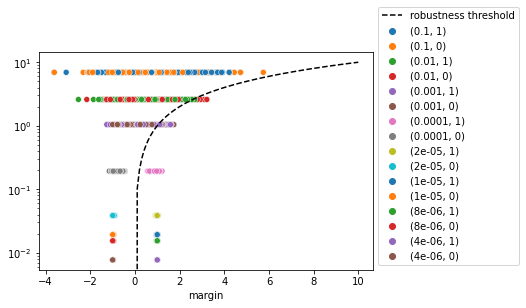

In [14]:
sub_df = df[df.ds_name == "mnist-test[:512]"]
hues = pd.Series(zip(sub_df.c, sub_df.y), index=sub_df.index, dtype="category")
hues.cat.set_categories(new_categories=hues.cat.categories[::-1], ordered=True, inplace=True)
splt = sns.scatterplot(
    x=sub_df.margin,
    y=sub_df.grad_norm * sub_df.attack_eps,
    hue=hues,
    palette=sns.color_palette(n_colors=hues.nunique())
);
splt.plot(
    np.linspace(0, 10, 100),
    np.linspace(0, 10, 100),
    '--', color="black",
    label="robustness threshold"
);
plt.yscale("log");
plt.legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1);

### grad-norm vs. norm vs. C

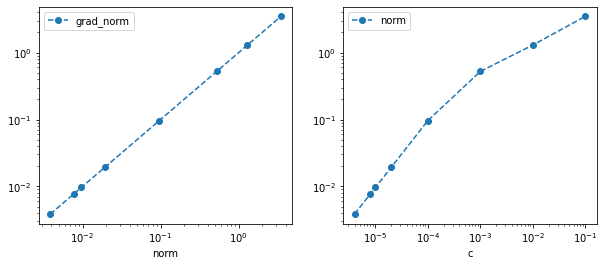

In [15]:
sub_df = (
df[df.ds_name == "mnist-test[:512]"]
    [["c", "grad_norm", "norm"]]
    .groupby("c", as_index=False).mean()
)

plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 2, 1)
sub_df.plot(ax=ax, x="norm", y="grad_norm", marker="o", linestyle="--", logx=True, logy=True);

ax = plt.subplot(1, 2, 2)
sub_df.plot(ax=ax, x="c", y="norm", marker="o", linestyle="--", logx=True, logy=True);

## RBF kernel

In [16]:
%%time
CUR_KEY = "svm-rbf"
RESULTS[CUR_KEY] = []
print(f"Running {CUR_KEY}...")

for c in [1e-3, 2e-3, 4e-3, 8e-3, 1e-2, 1e-1, 1, 10, 100]:
    clf = thundersvm.SVC(kernel="rbf", C=c)
    clf.fit(MNIST_TRAIN.xs[:1000], MNIST_TRAIN.ys[:1000])
    
    RESULTS[CUR_KEY].append(eval_clf(
        clf=clf,
        base_dict=dict(c=c),
        datasets=[ds_prefix(MNIST_TRAIN, 512), ds_prefix(MNIST_TEST, 512)],
        verbose=True,
        attack_eps=2.0,
        pgd_step_size=2.0/10,
        pgd_num_steps=20,
        batch_size=512,
    ))

Running svm-rbf...
{'c': '1.00e-03', 'n_support': [498, 498], 'b': '9.95e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=0.04629705052599714
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '2.00e-03', 'n_support': [498, 498], 'b': '9.89e-01', 'gam': '1.28e-03', 'coef0': '0.00e+00', 'attack_eps': '2.00e+00', 'pgd_step_size': '2.00e-01', 'pgd_num_steps': 20, 'batch_size': 512}
norm=0.09256605824309805
{'ds_name': 'mnist-train[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'ds_name': 'mnist-test[:512]', 'accs': '(0.0000, 1.0000)', 'accs_pgd': '(0.0000, 1.0000)', 'accs_linadv': '(0.0000, 1.0000)'}
{'c': '4.00e-03', 'n_support': 

### Visualize adv. examples found via pgd
These are clipped to to have pixel values in $[0, 1]$.

Natural
[0 0 0 1 1 1 0 1 0 0]


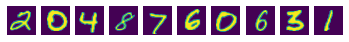


Adversarial
[0 0 0 1 1 1 0 1 0 0]


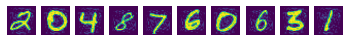

In [17]:
print("Natural")
dataset.plot_images(MNIST_TEST, channels=1)
print()
print("Adversarial")
dataset.plot_images(
    dataset.Dataset(xs=RESULTS["svm-rbf"][-1]["ds_results"][1]["xs_pgd"], ys=MNIST_TEST.ys),
    channels=1
)

### nat-err vs. adv-err as $C$ is varied

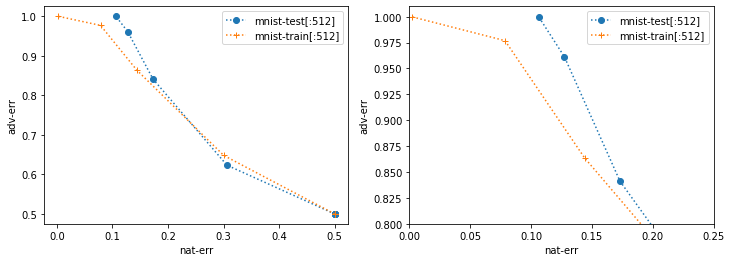

In [18]:
def main_plot():
    num_ds = len(RESULTS["svm-rbf"][0]["ds_results"])
    
    for ds_idx, fmt in zip([1, 0], ["o:", "+:"]):
        ds_name = RESULTS["svm-rbf"][0]["ds_results"][ds_idx]["ds_name"]
        
        accs = []
        accs_pgd = []
        for res_dict in RESULTS["svm-rbf"]:
            ds_dict = res_dict["ds_results"][ds_idx]
            accs.append(sum(ds_dict[f"accs"]) / 2.0)
            accs_pgd.append(sum(ds_dict[f"accs_pgd"]) / 2.0)

        accs = np.array(accs)
        accs_pgd = np.array(accs_pgd)

        plt.plot(1 - accs, 1 - accs_pgd, fmt, label=ds_name)
    
    plt.xlabel("nat-err");
    plt.ylabel("adv-err");
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1);
    
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
main_plot()

plt.subplot(1, 2, 2)
main_plot()
plt.xlim(0, 0.25);
plt.ylim(0.8, 1.01);

Tradeoff between nat-err and adv-err also seen for the rbf kernel.

### Build dataframe

In [19]:
res_dfs = []
for res_dict in RESULTS["svm-rbf"]:
    for ds_dict in res_dict["ds_results"]:
        cur_df = pd.DataFrame(dict(
            margin=ds_dict["sfmargs"],
            grad_norm=ds_dict["grad_norms"],
            y=ds_dict["ys"],
            ds_name=ds_dict["ds_name"],
            attack_eps=res_dict["attack_eps"],
            c=res_dict["c"],
            norm=res_dict["norm"],
            gam=res_dict["gam"],
        ))
        res_dfs.append(cur_df)

df = pd.concat(res_dfs, ignore_index=True)
df

,margin,grad_norm,y,ds_name,attack_eps,c,norm,gam
0,-0.997447,0.002207,0,mnist-train[:512],2.0,0.001,0.046297,0.001276
1,-0.993249,0.002205,0,mnist-train[:512],2.0,0.001,0.046297,0.001276
2,-0.994872,0.002112,0,mnist-train[:512],2.0,0.001,0.046297,0.001276
3,1.001033,0.002131,1,mnist-train[:512],2.0,0.001,0.046297,0.001276
4,0.994065,0.002113,1,mnist-train[:512],2.0,0.001,0.046297,0.001276
...,...,...,...,...,...,...,...,...
9211,0.495544,3.292261,0,mnist-test[:512],2.0,100.000,127.810428,0.001276
9212,1.445981,3.243687,1,mnist-test[:512],2.0,100.000,127.810428,0.001276
9213,0.303783,3.264163,0,mnist-test[:512],2.0,100.000,127.810428,0.001276
9214,-2.862697,3.236629,0,mnist-test[:512],2.0,100.000,127.810428,0.001276


### Study sfmarg vs. grad_norm

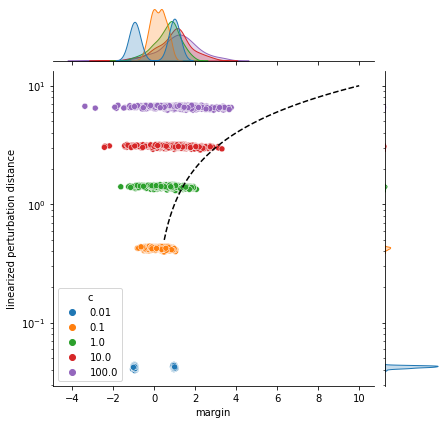

In [20]:
sub_df = df[df.ds_name == "mnist-test[:512]"]
sub_df = sub_df[(sub_df.c >= 0.01)]

#hues = pd.Series(zip(sub_df.c, sub_df.y), index=sub_df.index, dtype="category")
jplt = sns.jointplot(
    ax=ax,
    x=sub_df.margin,
    y=sub_df.grad_norm * sub_df.attack_eps,
    hue=sub_df.c.astype("category"),
);
jplt.ax_joint.plot(
    np.linspace(0.5, 10, 100),
    np.linspace(0.5, 10, 100),
    '--', color="black",
    label="robustness threshold"
);
jplt.ax_joint.set_ylabel("linearized perturbation distance");
plt.yscale("log");

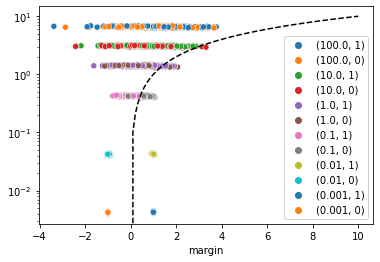

In [21]:
sub_df = df[df.ds_name == "mnist-test[:512]"]
sub_df = sub_df[(sub_df.c <= 0.001) | (sub_df.c >= 0.01)]

hues = pd.Series(zip(sub_df.c, sub_df.y), index=sub_df.index, dtype="category")
hues.cat.set_categories(new_categories=hues.cat.categories[::-1], ordered=True, inplace=True)

splt = sns.scatterplot(x=sub_df.margin, y=sub_df.grad_norm * sub_df.attack_eps, hue=hues, palette=sns.color_palette(n_colors=hues.nunique()));
splt.plot(
    np.linspace(0, 10, 100),
    np.linspace(0, 10, 100),
    '--', color="black",
    label="robustness threshold"
);
plt.yscale("log");

### grad-norm vs. norm vs. C

In [22]:
print(df.gam.unique())
GAM = df.gam.unique()[0]

[0.00127551]


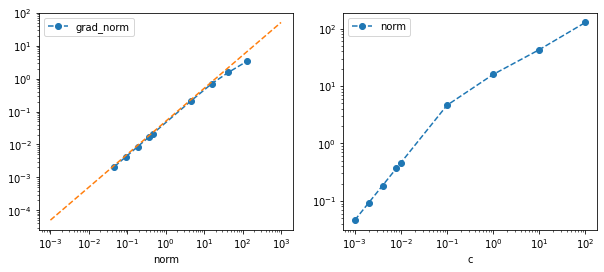

In [23]:
sub_df = (
df[df.ds_name == "mnist-test[:512]"]
    [["c", "grad_norm", "norm"]]
    .groupby("c", as_index=False).mean()
)

plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 2, 1)
sub_df.plot(ax=ax, x="norm", y="grad_norm", marker="o", linestyle="--", logx=True, logy=True);

xs = np.power(10, np.linspace(start=-3, stop=3, num=100))

ys = xs * np.sqrt(2 * GAM) 
plt.plot(xs, ys, linestyle="--")

ax = plt.subplot(1, 2, 2)
sub_df.plot(ax=ax, x="c", y="norm", marker="o", linestyle="--", logx=True, logy=True);

Note the almost perfect fit by the orange line.
How can this be?

The reason is for a kernel classifier $f$
with a kernel of the form
$k(x,x') = \varphi(\|x - x\|')$
for a decreasing function $\varphi: \mathbb{R}^+ \to \mathbb{R}$,
the worst-case perturbation to the functional-margin
of any datapoint $x$ w.r.t $f$
under an adversary which can make $\epsilon$-$\|\cdot\|$ perturbations
is exactly
$$\|f\|_\mathcal{H} \cdot \sqrt{2} \cdot \sqrt{\varphi(0) - \varphi(\epsilon)}.$$

For a RBF kernel classifier,
$$\varphi(x) = \exp\left( - \gamma \cdot x^2\right).$$

Thus the PGD gradient norm should be independent of $x$ and is just
$$
\|f\|_\mathcal{H} \cdot \sqrt{2} \cdot \lim_{\epsilon \to 0^+} \frac{d\sqrt{\varphi(0) - \varphi(\epsilon)}}{d\epsilon}
= \|f\|_\mathcal{H} \cdot \sqrt{2} \cdot \sqrt{\gamma}.
$$
per Wolfram-Alpha. The reason we need to take a limit is that the derivative is undefined at exactly 0.

We hypothesize that the reason for the deviation from the orange line
is due to numerical issues arising from the fact that the gradient is undefined at 0.